<a href="https://colab.research.google.com/github/andrewyzhuang/mae271D/blob/finalproj-janet-ann/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration 0 cost: 222.4505685442, Safe set size: 101
Iteration 1 cost: 49.9164937426, Safe set size: 15
Iteration 2 cost: 49.9164831281, Safe set size: 15
Iteration 3 cost: 49.9164829541, Safe set size: 15
Iteration 4 cost: 49.9164829280, Safe set size: 15
Iteration 5 cost: 49.9164829226, Safe set size: 15
Iteration 6 cost: 49.9164829214, Safe set size: 15
Iteration 7 cost: 49.9164829212, Safe set size: 15
Iteration 8 cost: 49.9164829211, Safe set size: 15
Iteration 9 cost: 49.9164829211, Safe set size: 15
Elapsed time: 10.732957 seconds


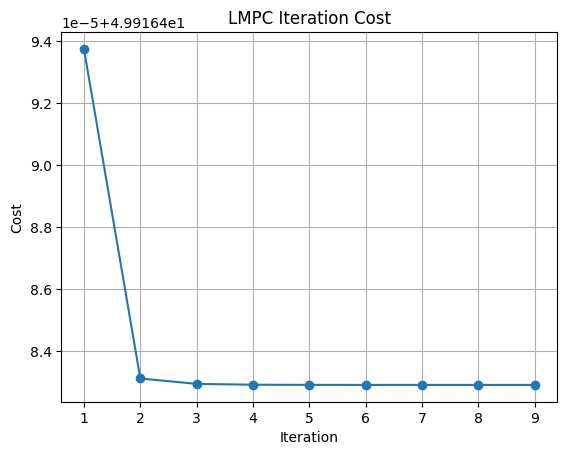

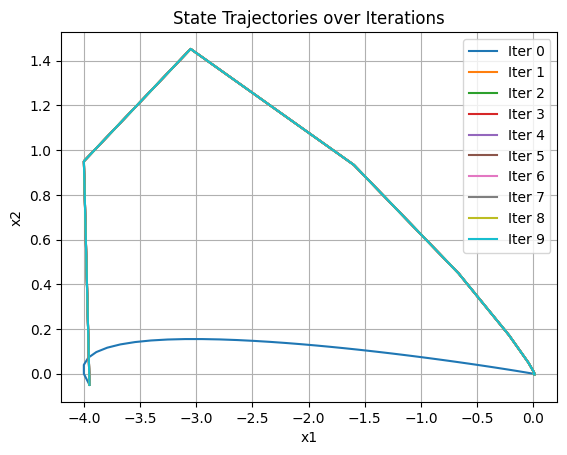

In [ ]:
# LMPC for Constrained LQR in Python (Single Script Version)

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, Delaunay
import time
import pdb

# record start time
start_time = time.time()

# System parameters
A = np.array([[1, 1], [0, 1]])
B = np.array([[0], [1]])
Q = np.eye(2)
R = np.eye(1)

x_min = np.array([-4, -4])
x_max = np.array([4, 4])
u_min = np.array([-1])
u_max = np.array([1])

x0 = np.array([-3.95, -0.05])
xF = np.zeros(2)
N = 4
max_iters = 9
tol = 1e-4

# Function to compute initial feasible trajectory using a naive controller
def initial_trajectory(A, B, Q, R, x0, xF, u_min, u_max, tol, max_steps = 100):
    x_traj = [x0]
    u_traj = []
    x = x0.copy()
    for _ in range(max_steps):
        # Weak, inefficient control: slow damping of velocity
        u = np.clip(-0.2 * x[1] - 0.01 * x[0], u_min, u_max)
        x = A @ x + B @ u
        x_traj.append(x.copy())
        u_traj.append(np.array([u]))
        if np.linalg.norm(x - xF) < tol:
            break
    return np.array(x_traj), np.array(u_traj)

# Compute cost-to-go for each point in trajectory
def compute_cost_to_go(x_traj, u_traj, Q, R):
    costs = []
    for t in range(len(x_traj)):
      cost = 0.0
      # Iterate over the future trajectory from the current point t
      for k in range(t, len(x_traj) - 1):
        x = x_traj[k]
        u = u_traj[k]
        cost += (x.T @ Q @ x).item() + (u.T @ R @ u).item()

      # Add terminal cost from the last state
      if len(x_traj) > 0: # Check if trajectory is not empty
        cost += (x_traj[-1].T @ Q @ x_traj[-1]).item()

      costs.append(cost)
    return np.array(costs)

# LMPC solver with convex hull terminal constraint and barycentric cost interpolation
def solve_lmpc_barycentric(A, B, Q, R, N, x0, ss_x, ss_cost, x_min, x_max, u_min, u_max):
    n = A.shape[0]
    m = B.shape[1]

    x = cp.Variable((n, N+1))
    u = cp.Variable((m, N))
    cost = 0
    constraints = [x[:, 0] == x0]

    for k in range(N):
        cost += cp.quad_form(x[:, k], Q) + cp.quad_form(u[:, k], R)
        constraints += [
            x_min <= x[:, k], x[:, k] <= x_max,
            u_min <= u[:, k], u[:, k] <= u_max,
            x[:, k+1] == A @ x[:, k] + B @ u[:, k]
        ]

    if len(ss_x) > 0:
        L = len(ss_x)
        lambdas = cp.Variable(L)
        ss_x_mat = np.array(ss_x).T
        ss_cost_vec = np.array(ss_cost)

        constraints += [
            x[:, N] == ss_x_mat @ lambdas,
            cp.sum(lambdas) == 1,
            lambdas >= 0
        ]

        terminal_cost = ss_cost_vec @ lambdas
        cost += terminal_cost

    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(solver=cp.OSQP)

    return u[:, 0].value


def trim_to_convex_hull(ss_x, ss_cost, n_extra=3):
    if len(ss_x) <= 2:
        return ss_x, ss_cost
    points = np.array(ss_x)
    try:
        hull = ConvexHull(points)
        indices = list(hull.vertices)

        # Add the lowest-cost interior points
        remaining = list(set(range(len(ss_x))) - set(indices))
        remaining_sorted = sorted(remaining, key=lambda i: ss_cost[i])
        extra = remaining_sorted[:n_extra]

        final_indices = indices + extra
        return [ss_x[i] for i in final_indices], [ss_cost[i] for i in final_indices]
    except:
        return ss_x, ss_cost


# Run LMPC loop
ss_x = []
ss_cost = []

# Initial trajectory
x_traj, u_traj = initial_trajectory(A, B, Q, R, x0, xF, u_min, u_max, tol)
ss_x.extend(x_traj)
ss_cost.extend(compute_cost_to_go(x_traj, u_traj, Q, R))
init_cost = sum(x.T @ Q @ x + u.T @ R @ u for x, u in zip(x_traj[:-1], u_traj)) + x_traj[-1].T @ Q @ x_traj[-1]
init_x_traj = x_traj.copy()
print(f"Iteration {0} cost: {init_cost.item():.10f}, Safe set size: {len(ss_x)}")


all_costs = []
all_trajectories = []

for j in range(max_iters):
    x = x0.copy()
    traj_x = [x]
    traj_u = []

    for t in range(100):
        u = solve_lmpc(A, B, Q, R, N, x, ss_x, ss_cost, x_min, x_max, u_min, u_max)
        if u is None:
            print(f"Infeasible at iter {j+1}, step {t}")
            break
        x = A @ x + B @ u
        traj_x.append(x.copy())
        traj_u.append(u.copy())
        if np.linalg.norm(x - xF) < tol:
            break

    x_traj = np.array(traj_x)
    u_traj = np.array(traj_u)
    ss_x.extend(x_traj)
    ss_cost.extend(compute_cost_to_go(x_traj, u_traj, Q, R))

    # Trim safe set to convex hull
    ss_x, ss_cost = trim_to_convex_hull(ss_x, ss_cost)

    cost = sum(x.T @ Q @ x + u.T @ R @ u for x, u in zip(x_traj[:-1], u_traj)) + x_traj[-1].T @ Q @ x_traj[-1]
    all_costs.append(cost)
    all_trajectories.append(x_traj)
    print(f"Iteration {j+1} cost: {cost:.10f}, Safe set size: {len(ss_x)}")


end_time = time.time()  # Record the end time

elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"Elapsed time: {elapsed_time:.6f} seconds")


# Plot cost per iteration
plt.figure()
ind = np.arange(1, j + 2)
plt.plot(ind, all_costs, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('LMPC Iteration Cost')
plt.grid(True)
plt.show()

# Plot trajectories
plt.figure()
x_plot = np.array(init_x_traj)
plt.plot(x_plot[:, 0], x_plot[:, 1], label=f"Iter {0}")
for j, x_traj in enumerate(all_trajectories):
    x_plot = np.array(x_traj)
    plt.plot(x_plot[:, 0], x_plot[:, 1], label=f"Iter {j+1}")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('State Trajectories over Iterations')
plt.legend()
plt.grid(True)
plt.show()